# Prediction for NDF | Not NDF
## Top Level Prediction

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import datetime
import sklearn.metrics as metrics
import sklearn.svm as svm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime, date

%matplotlib inline

In [2]:
train_users_path = '../../Data/train_users_2.csv'
train_users = pd.read_csv(train_users_path)
sessions = pd.read_csv('../../Data/sessions.csv')

#Drop train users that are not in sessions
final_train_users = train_users[train_users['id'].drop_duplicates().isin(sessions['user_id'].drop_duplicates())]
final_train_users = final_train_users.reset_index()
final_train_users.head()

,index,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
1,137022,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
2,137023,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF
3,137024,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
4,137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB


In [3]:
sessions_path = '../../Data/sessions.csv'
sessions = pd.read_csv(sessions_path)
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# Season (not used)

In [26]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'
def get_season(now):
    date_format = "%Y-%m-%d"
    d1 = now
    now = datetime.strptime(d1, date_format)
    
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

enc = OneHotEncoder()
a = np.array(final_train_users['date_account_created'].apply(get_season))
a = a[:,np.newaxis]
dateFeat = enc.fit_transform(a)
dateFeat = dateFeat.toarray()

# Actions

In [5]:
def action_bool(action):
    user_action = sessions[sessions['action'] == action]
    performed = final_train_users['id'].isin(user_action['user_id'])
    colname = 'b_' + action
    final_train_users[colname] = performed

#all actions
actions = sessions['action'].dropna().drop_duplicates()
for action in actions:
    action_bool(action)
    
final_train_users.head()

,index,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,b_south-america,b_braintree_client_token,b_view,b_stpcv,b_set_minimum_payout_amount,b_support_phone_numbers,b_refund_guest_cancellation,b_accept_decline,b_deactivated,b_rest-of-world
0,137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
1,137022,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
2,137023,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
3,137024,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
4,137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,...,False,False,False,False,False,False,False,False,False,False


# Set up Data

In [6]:
feats = map(lambda x: 'b_' + x,actions)
X = final_train_users[feats + ['country_destination']]
Xsh = shuffle(X,random_state = 42).reset_index()
Xsh = Xsh.as_matrix()[:,1:]
#Xsh = np.concatenate((dateFeat,Xsh),axis=1)
ntrain = 50000

Xtrain = Xsh[:ntrain,:-1]
ytrain = np.ravel(Xsh[:ntrain,-1:] != 'NDF')

Xval = Xsh[ntrain:,:-1]
yval = np.ravel(Xsh[ntrain:,-1:] != 'NDF')

print Xtrain.shape, ytrain.shape, Xval.shape, yval.shape

print 'Non NDF in train: {0}'.format(sum(ytrain))
print 'Non NDF in val: {0}'.format(sum(yval))

(50000, 359) (50000,) (23815, 359) (23815,)
Non NDF in train: 19441
Non NDF in val: 9333


# Random Forest

AUC ROC curve: 0.711666860732
Valid accuracy 0.88658
Val accuracy 0.694310308629
Number of Actions 359


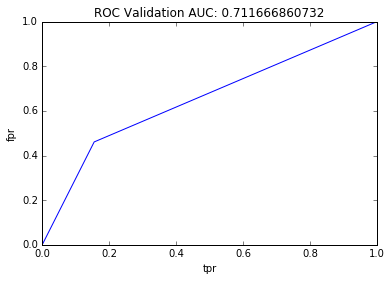

In [7]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(Xtrain,ytrain)
pred_train = clf.predict(Xtrain)
pred_val = clf.predict(Xval)

fpr,tpr,_ = metrics.roc_curve(yval,pred_val)
auc_roc = metrics.roc_auc_score(yval,clf.predict_proba(Xval)[:,1])

print 'AUC ROC curve: {0}'.format(auc_roc)
print 'Valid accuracy {0}'.format(np.mean(pred_train == ytrain))
print 'Val accuracy {0}'.format(np.mean(pred_val == yval))
print 'Number of Actions {0}'.format(len(actions))

plt.plot(fpr,tpr)
plt.title('ROC Validation AUC: {0}'.format(auc_roc))
plt.ylabel('fpr')
plt.xlabel('tpr')
plt.show()

# K fold

In [8]:
kf = KFold(n_splits=5,shuffle=True, random_state=42)

score = []
fpr = []
tpr = []
roc_auc = []
for train_index, val_index in kf.split(Xsh):
    X_train, X_val = Xsh[train_index,:-1], Xsh[val_index,:-1]
    y_train, y_val = np.ravel(Xsh[train_index,-1:] != 'NDF'), np.ravel(Xsh[val_index,-1:] != 'NDF')
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    
    pred_val = clf.predict_proba(X_val)[:,1]

    f,t,_ = metrics.roc_curve(y_val,pred_val)
    auc = metrics.roc_auc_score(y_val,pred_val)
    
    fpr.append(f)
    tpr.append(t)
    roc_auc.append(auc)
    
print roc_auc

[0.70523951376841021, 0.70303799947260659, 0.70714613897921486, 0.71452588962513985, 0.71014785816063641]


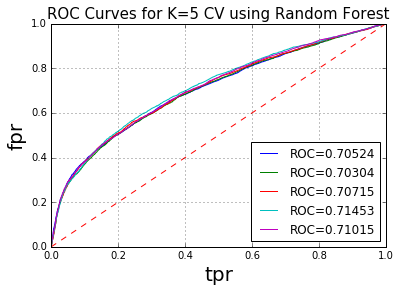

In [42]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.hold
plt.grid()
for i in range(len(fpr)):
    plt.plot(fpr[i],tpr[i],label='ROC={0:.5f}'.format(roc_auc[i]))

plt.plot([0,1],[0,1],linestyle='--',color='r')
    
plt.ylabel('fpr',fontsize=20)
plt.xlabel('tpr',fontsize=20)
plt.title('ROC Curves for K=5 CV using Random Forest',fontsize=15)
plt.legend(loc=4)
plt.show()